## Homework 6. Decision Trees

In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from itertools import product
import xgboost as xgb

from matplotlib import pyplot as plt
%matplotlib inline

### Data preparation

In [3]:
df = pd.read_csv(
    "../../W2/homework/housing.csv",
    names=[
        "latitude", "longitude", "housing_median_age", "total_rooms",
        "total_bedrooms", "population", "households", "median_income",
        "median_house_value", "ocean_proximity"
        ],
    header=0
    )

In [4]:
df = df.fillna(0)

In [5]:
df["median_house_value"] = np.log(df.median_house_value)

y = df.median_house_value
del df["median_house_value"]
X = df

#### Split the data

In [6]:
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
    )

X_train,  X_val, y_train, y_val = train_test_split(
    X_full_train, y_full_train, test_size=0.25, random_state=1
    )

len(y_train), len(y_test), len(y_val)

(12384, 4128, 4128)

#### feature-encoding

In [7]:
dv = DictVectorizer(sparse=False)

In [8]:
x_train_dict = X_train.to_dict(orient="records")
X_train_dv = dv.fit_transform(x_train_dict)

In [9]:
x_val_dict = X_val.to_dict(orient="records")
X_val_dv = dv.transform(x_val_dict)

# x_test_dict = X_test[selected].to_dict(orient="records")
# X_test_dv = dv.transform(x_test_dict)

### Question 1. Best split

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train_dv, y_train)
print(dt)

DecisionTreeRegressor(max_depth=1)


In [11]:
print(export_text(dt, feature_names=dv.get_feature_names_out().tolist()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



### Question 2. Random Forest validation RMSE

In [12]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_dv, y_train)
print(rf)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)


In [13]:
y_pred = rf.predict(X_val_dv)
mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False).round(2)

0.25

### Question 3. Select number of estimators

In [14]:
score = []
params = np.arange(10, 201, 10)
for n_estimators in params:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train_dv, y_train)
    y_pred = rf.predict(X_val_dv)
    score.append(mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False))

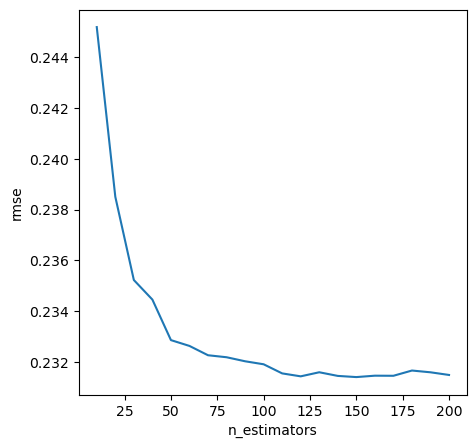

In [15]:
plt.figure(figsize=(5, 5))
plt.plot(params, score)
plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.show()

### Question 4. Best max_depth

In [16]:
md_list = [10, 15, 20, 25]
ne_list = params

In [17]:
score = []
for md, ne in product(md_list, ne_list):
    rf = RandomForestRegressor(n_estimators=ne, max_depth=md, random_state=1, n_jobs=-1)
    rf.fit(X_train_dv, y_train)
    y_pred = rf.predict(X_val_dv)
    score.append(mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False))

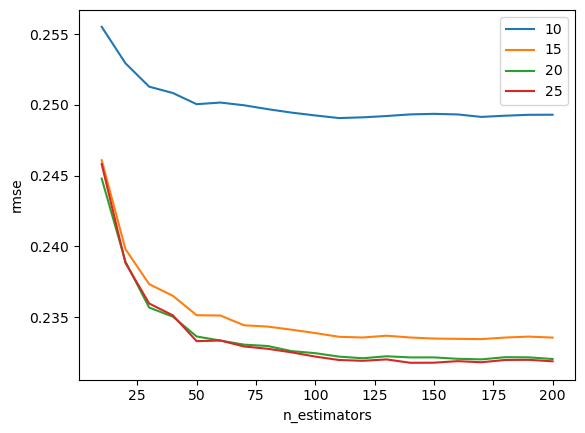

In [18]:
res_df = pd.DataFrame(
    np.asarray(score).reshape(len(md_list), -1).T, 
    columns=md_list, 
    index=params
    )
for column in res_df:
    plt.plot(res_df[column], label=column)
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.show()

### Question 5. Most important feature

In [19]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train_dv, y_train)
print(rf)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)


In [20]:
dv.get_feature_names_out()[rf.feature_importances_.argmax()]

'median_income'

### Question 6. Best eta

In [33]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [22]:
features = dv.get_feature_names_out().tolist()
new_features = []
for i in features:
    new_features.append(i.replace("<", "_"))

In [23]:
dtrain = xgb.DMatrix(X_train_dv, label=y_train, feature_names=new_features)
dval = xgb.DMatrix(X_val_dv, label=y_val, feature_names=new_features)

In [24]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [35]:
scores = {}

In [44]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [45]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

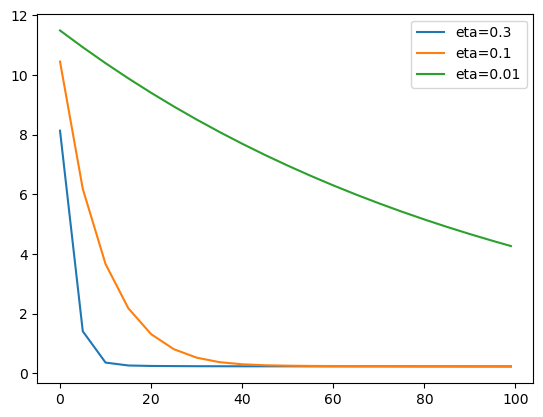

In [46]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.rmse, label=eta)

plt.legend()